In [ ]:
!pip install faiss-cpu
import faiss
!pip install timm

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import timm
import matplotlib.pyplot as plt
from PIL import Image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

cifar100_train = torchvision.datasets.CIFAR100(root='./data', train=True,
                                               download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar100_train, batch_size=64, shuffle=False)

100%|██████████| 169M/169M [00:13<00:00, 13.0MB/s]


In [ ]:
# Step 2: Load EfficientNet variants using timm
model_names = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3']
models = {name: timm.create_model(name, pretrained=True, num_classes=0).eval() for name in model_names}


# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [ ]:
# Step 3: Extract and index features using FAISS
index_dict = {}
features_dict = {}
labels = []

for model_name, model in models.items():
    model = model.to(device)
    features = np.empty((0, model.num_features), dtype='float32')
    for images, targets in tqdm(train_loader, desc=f"Extracting features with {model_name}"):
        images = images.to(device)
        with torch.no_grad():
            feats = model(images).cpu().numpy().astype('float32')
        features = np.vstack((features, feats))
        if model_name == 'efficientnet_b0':
            labels.extend(targets.numpy())

    faiss.normalize_L2(features)
    index = faiss.IndexFlatIP(features.shape[1])
    index.add(features)

    index_dict[model_name] = index
    features_dict[model_name] = features


Extracting features with efficientnet_b3: 100%|██████████| 782/782 [04:16<00:00,  3.05it/s]


In [ ]:
# Step 4: Define retrieval functions
def retrieve_similar_images(query_image, model_name='efficientnet_b0', top_k=5):
    model = models[model_name].to(device)
    index = index_dict[model_name]

    query = transform(query_image).unsqueeze(0).to(device)
    with torch.no_grad():
        q_feat = model(query).cpu().numpy().astype('float32')
        faiss.normalize_L2(q_feat)

    D, I = index.search(q_feat, top_k)
    return I[0], D[0]

In [ ]:
def retrieve_similar_images_faiss(query_features, faiss_index, k=10):
    faiss.normalize_L2(query_features)
    D, I = faiss_index.search(query_features, k)
    return I[0], D[0]

In [ ]:
# Step 5: Visualization (optional)
def show_retrieval(query_img, retrieved_indices):
    fig, axes = plt.subplots(1, len(retrieved_indices)+1, figsize=(15, 5))
    axes[0].imshow(query_img)
    axes[0].set_title("Query")
    axes[0].axis('off')
    for i, idx in enumerate(retrieved_indices):
        img, _ = cifar100_train[idx]
        img = img.permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # Unnormalize
        axes[i+1].imshow(img)
        axes[i+1].set_title(f"Top-{i+1}")
        axes[i+1].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_retrieval(query_idx, retrieved_indices, dataset, title="FAISS Retrieval", k=10, class_names=None):
    query_img, query_label = dataset[query_idx]
    fig, axes = plt.subplots(1, k + 1, figsize=(15, 5))
    axes[0].imshow((query_img.permute(1, 2, 0).numpy() * 0.5 + 0.5))
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, idx in enumerate(retrieved_indices):
        retrieved_img, label = dataset[idx]
        img = retrieved_img.permute(1, 2, 0).numpy() * 0.5 + 0.5
        axes[i+1].imshow(img)
        axes[i+1].set_title(f"Top-{i+1}" if class_names is None else class_names[label])
        axes[i+1].axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

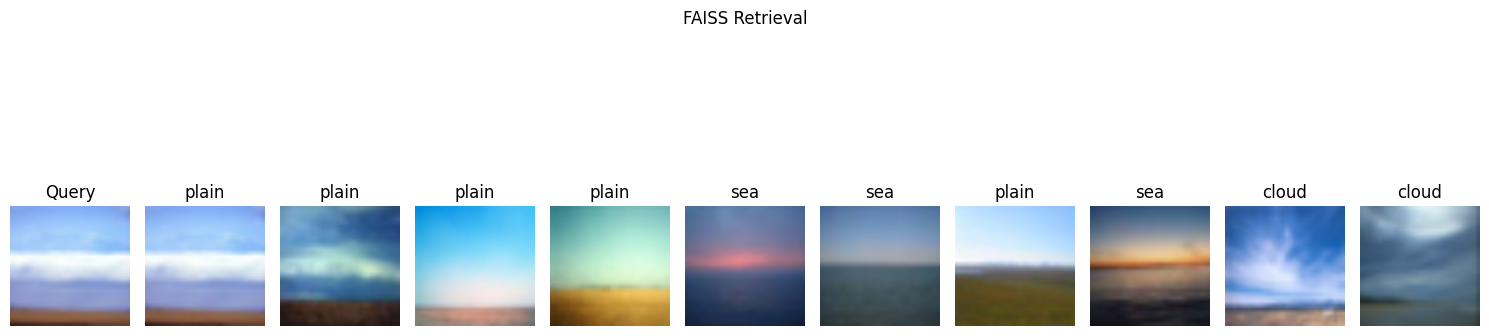

Precision@10: 0.50


In [ ]:
if __name__ == '__main__':
    model_variant = 'efficientnet_b3'
    model = models[model_variant].to(device)
    faiss_index = index_dict[model_variant]
    dataset = cifar100_train

    # Select a random query image
    query_idx = 300  # customised index
    query_image, query_label = dataset[query_idx]
    query_image_tensor = query_image.unsqueeze(0).to(device)

    with torch.no_grad():
        query_features = model(query_image_tensor).cpu().numpy().astype('float32')

    # Retrieve similar images
    k = 10  # Number of top matches to retrieve
    faiss_indices, _ = retrieve_similar_images_faiss(query_features, faiss_index, k=k)

    # Visualize retrieval results
    class_names = dataset.classes
    visualize_retrieval(query_idx, faiss_indices, dataset, title="FAISS Retrieval", k=k, class_names=class_names)

    # Step 7: Compute Precision@k
    correct = 0
    for idx in faiss_indices:
        _, label = dataset[idx]
        if label == query_label:
            correct += 1
    precision_at_k = correct / k
    print(f"Precision@{k}: {precision_at_k:.2f}")
